In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST("./", download=True, train=True)
MNIST_test = torchvision.datasets.MNIST("./", download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
X_train = MNIST_train.data
y_train = MNIST_train.targets
X_test = MNIST_test.data
y_test = MNIST_test.targets

In [5]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [6]:
X_train = X_train.float()
X_test = X_test.float()

In [7]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [8]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

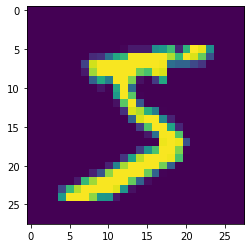

tensor(5)


In [9]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [15]:
X_train = X_train.reshape([-1, 28*28])
X_test = X_test.reshape([-1, 28*28])

In [41]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28*28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x

mnist_net = MNISTNet(100)

In [42]:
torch.cuda.is_available()

True

In [43]:
!nvidia-smi

Tue Dec 13 07:16:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    31W /  70W |   1564MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
mnist_net = mnist_net.to(device)
# list(mnist_net.parameters())

In [45]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [47]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(40):
    order = np.random.permutation(len(X_train))

    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()

        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)

        preds = mnist_net.forward(X_batch)

        loss_value = loss(preds, y_batch)
        loss_value.backward()

        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu().detach().numpy())

    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean()
    test_accuracy_history.append(accuracy.cpu())
    print(accuracy)

tensor(0.9140, device='cuda:0')
tensor(0.9204, device='cuda:0')
tensor(0.9197, device='cuda:0')
tensor(0.9259, device='cuda:0')
tensor(0.9300, device='cuda:0')
tensor(0.9298, device='cuda:0')
tensor(0.9288, device='cuda:0')
tensor(0.9295, device='cuda:0')
tensor(0.9312, device='cuda:0')
tensor(0.9335, device='cuda:0')
tensor(0.9339, device='cuda:0')
tensor(0.9289, device='cuda:0')
tensor(0.9327, device='cuda:0')
tensor(0.9341, device='cuda:0')
tensor(0.9358, device='cuda:0')
tensor(0.9369, device='cuda:0')
tensor(0.9352, device='cuda:0')
tensor(0.9357, device='cuda:0')
tensor(0.9305, device='cuda:0')
tensor(0.9386, device='cuda:0')
tensor(0.9432, device='cuda:0')
tensor(0.9395, device='cuda:0')
tensor(0.9399, device='cuda:0')
tensor(0.9394, device='cuda:0')
tensor(0.9407, device='cuda:0')
tensor(0.9414, device='cuda:0')
tensor(0.9416, device='cuda:0')
tensor(0.9438, device='cuda:0')
tensor(0.9430, device='cuda:0')
tensor(0.9427, device='cuda:0')
tensor(0.9435, device='cuda:0')
tensor(0

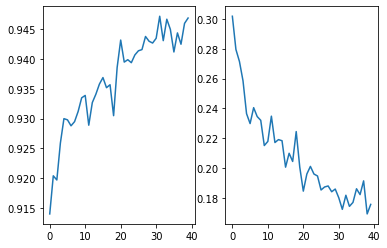

In [54]:
figure, axis = plt.subplots(1, 2)
axis[0].plot(test_accuracy_history)
axis[1].plot(test_loss_history)
plt.show()